# Chapter 04 신경망 학습



학습 : 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것

규칙을 '사람' 이 만드는 방식에서 '기계'가 데이터로부터 배우는 방식으로 패러다임이 전환됨.

- 머신러닝에서는 특징을 사람이 설계하는 것에 반해, **신경망**은 중요한 특성까지도 스스로 학습한다.

 딥러닝을 'end-to-end machine learning' 이라고도 한다.

 ---


### 4.2 손실 함수

손실함수 (비용함수) : 신경망 성능의 '나쁨'을 나타내는 지표

- 오차제곱합 (SSE) :

 **$E$ = $\frac{1}{2}$ $∑$ (예측값 - 정답)²**

 $\frac{1}{2}$ 을 붙이는 이유는 미분해서 계수를 1로 만들기 위해서

In [17]:
import numpy as np

# 오차제곱합 구현
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

t = [0 ,0, 1, 0, 0, 0, 0, 0 ,0, 0]   # 정답 == 2라는 뜻 (원-핫 인코딩)

# y: 신경망의 소프트맥스 함수의 출력
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]   # '2'일 확률이 제일 높다고 추정
print(sum_squares_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]   # '7'일 확률이 제일 높다고 추정
print(sum_squares_error(np.array(y), np.array(t)))

# 손실함수의 값이 더 작은 것을 정답에 더 가까울 것으로 판단!

0.09750000000000003
0.5975


- 교차 엔트로피 오차 (CEE) : 

 **$E$ = $-$ $∑$ (정답 x log(예측값))**

 --> 정답일 때 1, 아닐 때 0이므로 정답일 때의 추정의 자연로그를 계산하는 식이 된다. ( 원-핫 인코딩 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


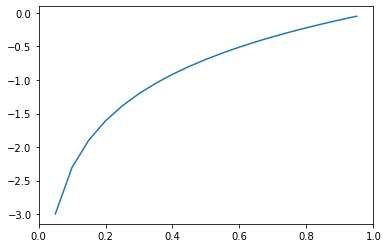

In [18]:
# 자연로그 그래프
import matplotlib.pyplot as plt
x = np.arange(0.0, 1.0, 0.05)
y = np.log(x)
plt.plot(x, y)
plt.xlim(0, 1)
plt.show()

정답의 예측값 ( 신경망의 출력값 )이 0에 가까울수록 오차가 커지고, 1에 가까워질수록 오차가 작아진다!

In [19]:
# 교차 엔트로피 구현
def cross_entropy_error(y, t):
    delta = 1e-7    # 아주 작은 값
    return -np.sum(t * np.log(y+delta))

# delta를 더해준 이유는 log()안에 0이 들어가면 오류가 발생하기 때문

In [20]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  # 정답은 '2'
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]  # 정답 '2'로 예측
print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]  # 정답 '7'로 예측
print(cross_entropy_error(np.array(y), np.array(t)))    

0.510825457099338
2.302584092994546


한 개의 데이터에 대해서 손실함수를 생각했는데, N개의 손실함수의 값을 다 구하여 평균을 내야한다! ( 평균 손실 함수 )

 **$E$ = $-$ $\frac{1}{N}$ $∑$ (정답 x log(예측값))**   
 
[ $N$ = 데이터 개수 ]

--> 데이터가 많아지면 시간이 많이 걸림...

- **미니배치 학습** :

 훈련 데이터로부터 일부만 골라 학습을 수행

In [21]:
# mnist 데이터셋 불러오기
import sys
import os
import numpy as np
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master'
sys.path.append(path)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) # 정규화o, 원-핫 인코딩o

print(x_train.shape)    # 훈련 이미지
print(t_train.shape)    # 정답 레이블

(60000, 784)
(60000, 10)


In [22]:
train_size = x_train.shape[0]  # == len(x_train)
batch_size = 10   # 배치크기 지정
batch_mask = np.random.choice(train_size, batch_size)  # random.choice(x, n): 0이상 x미만인 n개의 난수 생성
x_batch = x_train[batch_mask]   # batch_size 만큼 뽑음
t_batch = t_train[batch_mask]
print(x_batch.shape)
print(t_batch.shape)

(10, 784)
(10, 10)


In [23]:
np.random.choice(60000,10)

array([30302, 34990,  1842, 40063,  2564, 20198, 52468, 59377,  9632,
        3842])

In [24]:
# (배치용) 교차 엔트로피 구현하기
def cross_entropy_error(y, t):  # y: 신경망의 출력, t: 정답 레이블
    if y.ndim == 1:               # 데이터가 하나라면 reshape 적용 (ndim이 2인 것들과 통일하기 위해서)
        t = t.reshape(1, t.size)  # t.size : t의 총 원소 개수
        y = y.reshape(1, y.size)  # == y.flatten()
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [25]:
# 정답 레이블이 원-핫 인코딩이 아닌 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    # 원-핫 인코딩에서 정답이 0인 경우는 무시하고 계산하는 느낌

정확도 대신 **손실함수**를 사용하는 이유 :

- 신경망에서 손실함수를 가능한 작게 하는 매개변수의 값을 찾는데에 '미분'이 중요한 역할을 하기 때문에.

- 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 된다.

 정확도는 매개변수의 미소한 변화에 거의 반응을 보이지 않고, 있더라도 불연속적으로 갑자기 변화한다..

== '계단 함수'를 활성화 함수로 사용하지 않는 이유와 같다

### 4.3 수치 미분

미분 : 한순간의 변화량

$\frac{df(x)}{dx} = lim_{x \to \infty}\frac{f(x+h) - f(x)}{h}$

In [26]:
# 함수를 미분하는 계산 구현

# 나쁜 구현 예
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h)-f(x)) / h

- 문제1) 반올림 오차 발생

 너무 작은 값이 생략되어 오차가 생김

- 문제2) f의 차분

 미분값이 엄밀히 일치 하지 않음 (h를 무한히 0으로 좁히는 것이 불가능하기 때문)

 이 오차를 줄이기 위해 (x+h) 와 (x-h) 일 때의 f 차분을  계산하는 방법을 쓰기도 함 --> **'중심 차분' (중앙 차분)** 이라 한다.

전방 차분: $f(x+h) - f(x)$

중앙 차분: $f(x+h) - f(x-h)$

In [27]:
np.float32(1e-50)   # 반올림 오차

0.0

- **수치 미분** : 아주 작은 차분으로 미분하는 것 ( 근사치로 계산 )

차분 : 임의 두 점에서의 함수 값들의 차이

- 해석적 미분 : 오차를 포함하지 않는 '진정한 미분' 값을 구함

In [28]:
# 앞의 문제점을 개선한 수치미분 구현
def numerical_diff(f, x):   # x에서의 수치 미분값을 구하는 함수
    h = 1e-4  # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

In [29]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

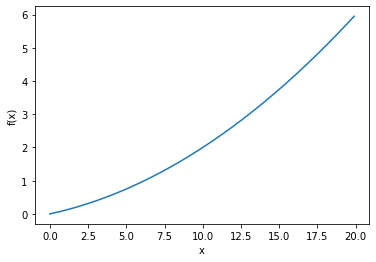

In [30]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x, y)
plt.show()

In [31]:
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


(function_1) 0.01$x^2$ + 0.1$x$ 의 해석적 해 :

$\frac{df(x)}{dx} = 0.02x + 0.1$ 

--> 오차가매우 작다.

0.1999999999990898
0.2999999999986347


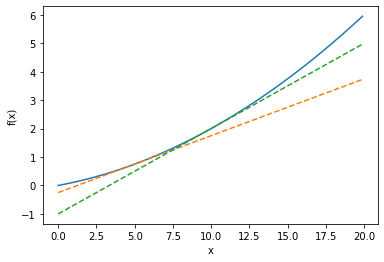

In [32]:
def tangent_line(f, x):     # 기울기 방정식을 구하는 함수
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x  # y절편
    return lambda t: d*t + y   # 함수를 return
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
tf1 = tangent_line(function_1, 10)
y2 = tf(x)
y3 = tf1(x)

plt.plot(x, y)
plt.plot(x, y2, '--')
plt.plot(x, y3, '--')
plt.show()

편미분 : 변수가 여렷인 함수에 대한 미분

In [33]:
def function_2(x):
    return x[0]**2 + x[1]**2
    # 또는 np.sum(x**2)

(function_2) $f(x_0, x_1) = x_0^2 + x_1^2$

In [34]:
# x0에 대한 편미분 (x0=3, x1=4 일 때)
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

### 4.4 기울기

- 기울기 : 모든 변수의 편미분을 벡터로 정리한 것

ex) 변수가 $x_0, x_1$ 일 때,

기울기 : $(\frac{∂f}{∂x_0}, \frac{∂f}{∂x_1})$

In [35]:
def numerical_gradient(f, x):   # x: 가중치로 생각
    h = 1e-4
    grad = np.zeros_like(x)  # x와 형상이 같은 배열 생성 (원소는 모두 0)

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)  # 중앙차분이라서 2*h로 나눠줌
        x[idx] = tmp_val   # 값 복원
    return grad

print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))

[6. 8.]
[0. 4.]


No handles with labels found to put in legend.


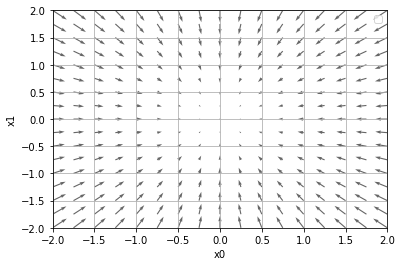

In [36]:
# 기울기의 결과에 마이너스를 붙인 벡터 그리기
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

위 그래프에서 화살표가 가르키는 쪽은 '가장 낮은 장소 (최솟값)' 이다

- **기울기가 가르키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향이다!**

---

**경사법** : 기울기를 잘 이용해 함수의 최솟값을 찾으려는 것

기울기가 0 이라고 무조건 최솟값이라고는 할 수 없다! (ex. 안장점)

$x_0 = x_0 - η\frac{∂f}{∂x_0}$

$x_1 = x_1 - η\frac{∂f}{∂x_1}$

[ η : 학습률 ] -- 갱신하는 양을 의미 ( 너무 크거나 너무 작으면 좋은 결과를 얻지 못함 )

In [37]:
# 경사 하강법 구현
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x   # 초깃값

    for i in range(step_num):   # step_num: 반복 횟수
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

$f(x_0, x_1) = x_0^2 + x_1^2$ 의 최솟값 구하기

In [38]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100))

# 거의 (0,0)에 가까운 결과이므로 정확한 결과를 얻음

[-6.11110793e-10  8.14814391e-10]


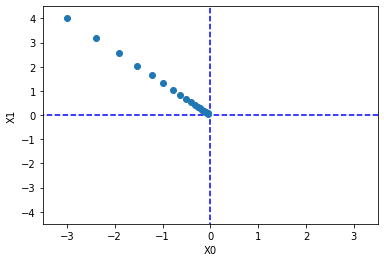

In [39]:
# 위 경사법에 의한 갱신 과정을 그림으로 표현
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)   # 그래프를 그리기 위해서 x_history 반환


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [40]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

# 학습률이 너무 큰 예: lr=10.0
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=10.0, step_num = 100))

[-2.58983747e+13 -1.29524862e+12]


In [41]:
# 학습률이 너무 작은 예: lr=1e-10
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100))

# 학습률은 하이퍼파라미터이므로 사람이 직접 설정해 주어야 함

[-2.99999994  3.99999992]


In [42]:
# 신경망을 예로 들어 실제로 기울기를 구하는 코드 구현
import sys
import os
path = "/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master"
sys.path.append(path)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet(object):
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [43]:
net = simpleNet()
print(net.W)

[[-1.07255262 -0.12003652 -0.41777198]
 [ 0.69713473  0.06826076  0.78322618]]


In [44]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p))

t = np.array([0, 0, 1])   # 정답 레이블
net.loss(x, t)

[-0.01611031 -0.01058723  0.45424037]
2


0.8122742133211963

In [45]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)
print()

f = lambda w: net.loss(x, t)    # 위 def 방식이랑 같다
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.16638499  0.16730649 -0.33369148]
 [ 0.24957748  0.25095973 -0.50053721]]

[[ 0.16638499  0.16730649 -0.33369148]
 [ 0.24957748  0.25095973 -0.50053721]]


### 4.5 학습 알고리즘 구현하기

신경망 학습 : 적응 가능한 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정

1. 미니배치

 훈련 데이터 중 일부를 무작위로 가져온다. ( 그 미니배치의 손실 함수의 값을 줄이는 것이 목표 )

2. 기울기 산출

 각 가중치 매개변수의 기울기를 구한다.

3. 매개변수 갱신

 가중치 매개변수를 기울기 방향으로 아주 조금 갱신

4. 1 ~ 3 단계를 반복

In [46]:
# 2층 신경망을 하나의 클래스로 구현

from common.functions import *  # 모두 import
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}    # 신경망의 매개변수를 보관하는 딕셔너리 변수
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) # 가중치 매개변수는 정규분포를 따르는 난수로 초기화
        self.params['b2'] = np.zeros(output_size)  # 편향은 0으로 초기화

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)  # t는 원-핫 인코딩으로 들어가므로 axis=1 을 할 수 있다!
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):   # 수치 미분 방식으로 매개변수의 기울기를 계산
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}    # 기울기를 보관하는 딕셔너리 변수
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):   # numerical_gradient()의 성능 개선판!
    #                             오차역전파법을 사용하여 기울기를 계산 (훨씬 빠름)
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [47]:
# random 모듈
print(np.random.randint(1,5,10))  # 1~4까지 중 난수 10개 생성
print(np.random.rand(3,2))  # 0~1 의 균일분포 (표준정규분포) 난수를 (3,2) 크기로 생성
print(np.random.randn(3,2)) # 평균: 0, 표준편차: 1인 표준정규분포 난수 생성

[1 2 1 1 1 2 3 1 3 3]
[[0.38555641 0.2620826 ]
 [0.30033214 0.18180254]
 [0.61752891 0.11125405]]
[[ 1.8385447   1.06278521]
 [ 2.31289479  0.25409394]
 [ 0.87210072 -0.37467921]]


In [48]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [49]:
x = np.random.rand(100, 784)    # 더미 입력 데이터
y = net.predict(x)

In [50]:
x = np.random.rand(100, 784) # 입력데이터
t = np.random.rand(100, 10)  # 정답 레이블
y = net.predict(x)           # 추론 결과

grads = net.gradient(x, t)   # 각 매개변수의 기울기를 계산

print(y.shape)
print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(100, 10)
(784, 100)
(100,)
(100, 10)
(10,)


미니배치 학습 구현하기:

훈련 데이터 중 일부를 무작위로 꺼내고 (미니배치), 그 미니배치에 대해서 경사법으로 매개변수 갱신

In [51]:
import numpy as np
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []   # 그래프를 그리기 위함

#하이퍼파라미터
iters_num = 10000   # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100    # 배치 크기
learning_rate = 0.1 # 학습률

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)  # random.choice(x, n) : 0~(x-1)까지의 난수 n개 생성
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)    # 그래프를 그리기 위함

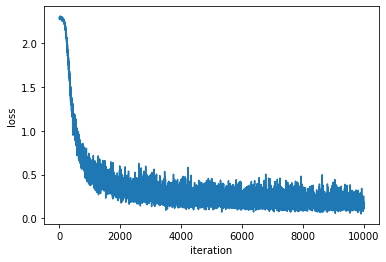

In [52]:
# 손실 함수 값의 추이
x = np.arange(iters_num)
y = train_loss_list
plt.plot(x,y)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# 반복횟수가 늘어가면서 손실 함수의 값이 줄어든다 --> 학습이 잘 되고 있음
# 그려보면서 눈으로 확인하는것을 습관화! 하이퍼파라미터 수정에 있어서 중요함!

시험 데이터로 평가하기

In [53]:
import numpy as np
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)   # 성능 개선판!
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        # 100 번 출력 되야되는거 아닌가????????????????????????????

train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.7840333333333334, 0.7888
train acc, test acc | 0.8758333333333334, 0.8798
train acc, test acc | 0.8984, 0.9028
train acc, test acc | 0.9084166666666667, 0.9119
train acc, test acc | 0.9140166666666667, 0.9161
train acc, test acc | 0.9199166666666667, 0.9223
train acc, test acc | 0.9235, 0.9256
train acc, test acc | 0.9273833333333333, 0.9289
train acc, test acc | 0.93095, 0.934
train acc, test acc | 0.9334166666666667, 0.9355
train acc, test acc | 0.9361166666666667, 0.9364
train acc, test acc | 0.9387, 0.9401
train acc, test acc | 0.9409833333333333, 0.9413
train acc, test acc | 0.9425333333333333, 0.941
train acc, test acc | 0.9442666666666667, 0.9432
train acc, test acc | 0.946, 0.9446


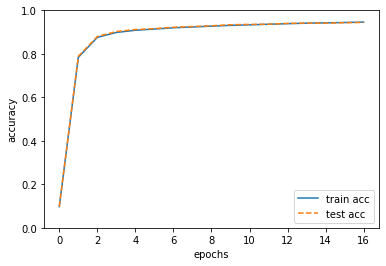

In [54]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 그래프를 보면 훈련데이터와 테스트데이터가 거의 겹쳐있다 --> 과대적합이 일어나지 않았다!